## Lucky cat

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

import clustergraph.clustergraph as cg
from clustergraph.utils import get_clusters_from_scikit
import clustergraph.plot_graph as pg

from sklearn.cluster import KMeans

## Download data

In [2]:
try:
    lucky = pd.read_csv("data/lucky_cat.csv", header=None).to_numpy(dtype=float)
except:
    print("reading data from github")
    lucky = pd.read_csv(
        "https://raw.githubusercontent.com/dioscuri-tda/pyBallMapper/refs/heads/main/notebooks/data/lucky_cat.csv",
        header=None,
    ).to_numpy(dtype=float)

print(lucky.shape)

(72, 16384)


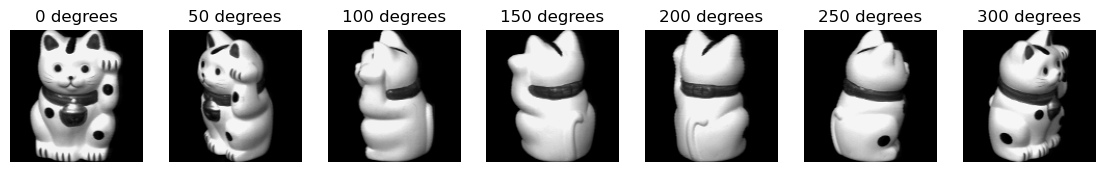

In [3]:
fig, axs = plt.subplots(ncols=7, figsize=(14, 5))

for i in range(7):
    axs[i].imshow(lucky[i * 10].reshape((128, 128)), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title("{:.0f} degrees".format(i * 10 / 72 * 360))

## Clustering

In [4]:
model = KMeans(15, random_state=42)
pred = model.fit_predict(lucky)

## ClusterGraph

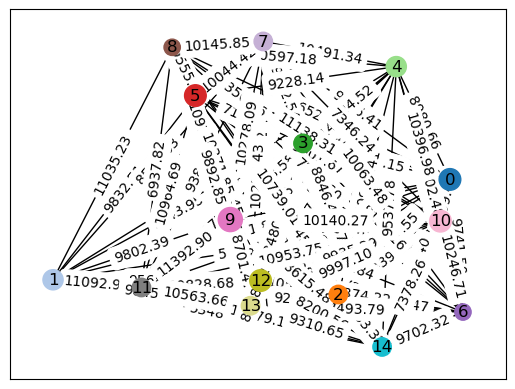

In [5]:
cluster_g = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(pred), X=lucky, metric_clusters="average"
)

# Coloring the graph
cluster_g.color_graph(
    node_color_labels=pred,
    node_palette=cm.get_cmap("tab20"),
)

pg.draw_graph(cluster_g.Graph, size_nodes=1000, random_state=42)

## Metric distortion pruning

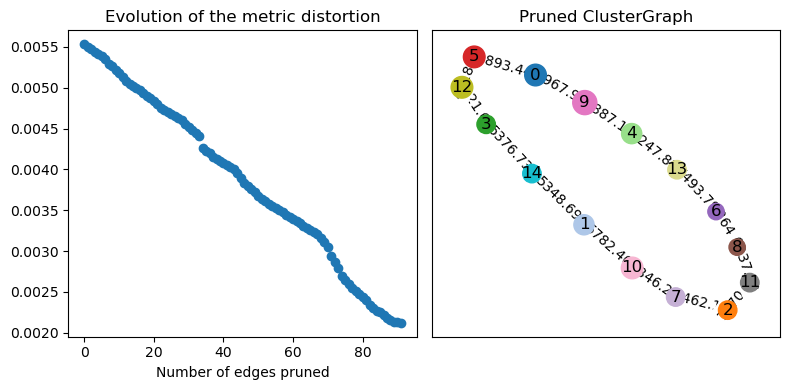

In [6]:
metric_distortion_graph, md = cluster_g.prune_distortion(knn_g=5, score=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

ax1.scatter(range(len(md)), md)
ax1.set_title("Evolution of the metric distortion")
ax1.set_xlabel("Number of edges pruned")

ax2.set_title("Pruned ClusterGraph")
metric_distortion_graph = cluster_g.prune_distortion()
pg.draw_graph(metric_distortion_graph, ax=ax2)

plt.tight_layout()
plt.show()

## Color by angle

In [7]:
# we use the angles as coloring functions, with circmean instead of artmetic mean
from scipy.stats import circmean

cluster_g.add_coloring(
    coloring_df=pd.DataFrame(
        data={"angle": np.linspace(0, 2 * np.pi, num=72, endpoint=False)}
    ),
    custom_function=circmean,
)

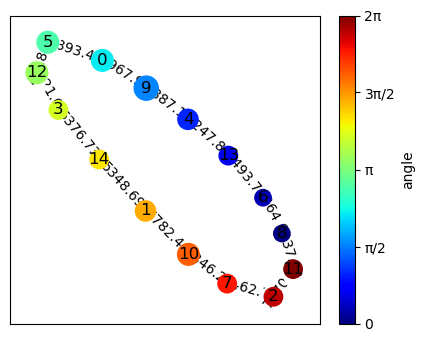

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 4))

# now each node in the CG has an attribute 'angle'
# and we can use it as a coloring function
cluster_g.color_graph(
    node_type_coloring="variable",
    node_variable="angle",
    node_palette=cm.get_cmap("jet"),
)

metric_distortion_graph = cluster_g.prune_distortion()
pg.draw_graph(metric_distortion_graph, size_nodes=1000, random_state=42, ax=ax)

# add a colorbar
from matplotlib.cm import ScalarMappable

# Create a ScalarMappable with the 'jet' colormap
cmap = plt.get_cmap("jet")
norm = plt.Normalize(0, 2 * np.pi)
mappable = ScalarMappable(norm=norm, cmap=cmap)

# Add a colorbar to the axis
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("angle")  # Label for the colorbar

# Set the ticks to show the range from 0 to 2π
cbar.set_ticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi])
cbar.set_ticklabels(["0", "π/2", "π", "3π/2", "2π"])